In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [33]:
data = pd.read_csv("../../Data/wa/Data gede masked olahan.csv", parse_dates=['Date','Last Update Time'])
df = data.copy()
df.head()

C:\Users\Jayy\AppData\Local\Temp\ipykernel_13564\1192523660.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../../Data/wa/Data gede masked olahan.csv", parse_dates=['Date','Last Update Time'])


,Email User,Nomor Telepon Tujuan,Status,Date,Last Update Time,jam last update,tanggal last update,hari last update,isWeekend last update,jam,tanggal,hari,Nomor Telepon Tujuan Prefix,provider,selisih
0,Email user 1,0821xxxxxxxx,read,2023-02-14 11:13:00,2023-02-14 11:14:00,11,14,Selasa,0,11,14,Selasa,0821,Telkomsel,0 days 00:01:00
1,Email user 1,0812xxxxxxxx,read,2023-02-14 11:13:00,2023-02-14 11:17:00,11,14,Selasa,0,11,14,Selasa,0812,Telkomsel,0 days 00:04:00
2,Email user 1,0838xxxxxxxx,read,2023-02-14 11:13:00,2023-02-14 11:15:00,11,14,Selasa,0,11,14,Selasa,0838,XL,0 days 00:02:00
3,Email user 1,0858xxxxxxxx,read,2023-02-14 11:13:00,2023-02-14 11:28:00,11,14,Selasa,0,11,14,Selasa,0858,Indosat,0 days 00:15:00
4,Email user 1,0858xxxxxxxx,delivered,2023-02-14 11:13:00,2023-02-14 11:13:00,11,14,Selasa,0,11,14,Selasa,0858,Indosat,0 days 00:00:00


In [34]:
df = df[(df['Status'] == 'read') | (df['Status'] == 'delivered')]

In [35]:
df['Status'].value_counts()

read         7048484
delivered    2257911
Name: Status, dtype: int64

In [36]:
df.dtypes

Email User                             object
Nomor Telepon Tujuan                   object
Status                                 object
Date                           datetime64[ns]
Last Update Time               datetime64[ns]
jam last update                         int64
tanggal last update                     int64
hari last update                       object
isWeekend last update                   int64
jam                                     int64
tanggal                                 int64
hari                                   object
Nomor Telepon Tujuan Prefix            object
provider                               object
selisih                                object
dtype: object

In [37]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

In [38]:
groupby = df.groupby(["Email User", "provider","hari", "hari last update", "jam", "jam last update","tanggal","tanggal last update", "selisih", "Status"]).size().unstack().sort_values(by="read", ascending=False)
groupby.dropna(inplace=True)
groupby['total'] = groupby['read'] + groupby['delivered']
groupby['read_rate'] = groupby['read'] / (groupby['read'] + groupby['delivered'])


scaller = MinMaxScaler()
groupby['read scalled'] = scaller.fit_transform(groupby[['read']])
groupby['delivered scalled'] = scaller.fit_transform(groupby[['delivered']])
groupby['weighted'] = (groupby['delivered scalled'] * 0.001) + (groupby['read scalled'] * 0.999)

groupby.sort_values(by=['read_rate', 'weighted'], ascending=False)
groupby = groupby.reset_index()
groupby

Status,Email User,provider,hari,hari last update,jam,jam last update,tanggal,tanggal last update,selisih,delivered,read,total,read_rate,read scalled,delivered scalled,weighted
0,Email user 161,Telkomsel,Rabu,Rabu,13,13,15,15,0 days 00:00:00,5841.0,4996.0,10837.0,0.461013,1.000000,0.326202,0.999326
1,Email user 161,Telkomsel,Senin,Senin,15,15,20,20,0 days 00:00:00,6615.0,4438.0,11053.0,0.401520,0.888288,0.369435,0.887769
2,Email user 49,Telkomsel,Sabtu,Sabtu,12,12,25,25,0 days 00:00:00,17904.0,4047.0,21951.0,0.184365,0.810010,1.000000,0.810200
3,Email user 161,Telkomsel,Senin,Senin,13,13,13,13,0 days 00:00:00,1857.0,3772.0,5629.0,0.670101,0.754955,0.103670,0.754304
4,Email user 161,Telkomsel,Rabu,Rabu,15,15,15,15,0 days 00:00:00,911.0,3646.0,4557.0,0.800088,0.729730,0.050829,0.729051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180940,Email user 19,Telkomsel,Selasa,Selasa,15,15,14,14,0 days 00:22:00,1.0,1.0,2.0,0.500000,0.000000,0.000000,0.000000
180941,Email user 19,Telkomsel,Selasa,Selasa,15,15,28,28,0 days 00:03:00,1.0,1.0,2.0,0.500000,0.000000,0.000000,0.000000
180942,Email user 19,Telkomsel,Selasa,Selasa,18,18,7,7,0 days 00:05:00,1.0,1.0,2.0,0.500000,0.000000,0.000000,0.000000
180943,Email user 19,Telkomsel,Selasa,Selasa,17,17,31,31,0 days 00:01:00,1.0,1.0,2.0,0.500000,0.000000,0.000000,0.000000


In [39]:
groupby = groupby.copy()
groupby.sort_values(by=['weighted'], ascending=False)

Status,Email User,provider,hari,hari last update,jam,jam last update,tanggal,tanggal last update,selisih,delivered,read,total,read_rate,read scalled,delivered scalled,weighted
0,Email user 161,Telkomsel,Rabu,Rabu,13,13,15,15,0 days 00:00:00,5841.0,4996.0,10837.0,0.461013,1.000000,0.326202,0.999326
1,Email user 161,Telkomsel,Senin,Senin,15,15,20,20,0 days 00:00:00,6615.0,4438.0,11053.0,0.401520,0.888288,0.369435,0.887769
2,Email user 49,Telkomsel,Sabtu,Sabtu,12,12,25,25,0 days 00:00:00,17904.0,4047.0,21951.0,0.184365,0.810010,1.000000,0.810200
3,Email user 161,Telkomsel,Senin,Senin,13,13,13,13,0 days 00:00:00,1857.0,3772.0,5629.0,0.670101,0.754955,0.103670,0.754304
4,Email user 161,Telkomsel,Rabu,Rabu,15,15,15,15,0 days 00:00:00,911.0,3646.0,4557.0,0.800088,0.729730,0.050829,0.729051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159472,Email user 71,Tri,Selasa,Selasa,13,19,28,28,0 days 06:40:00,1.0,1.0,2.0,0.500000,0.000000,0.000000,0.000000
159469,Email user 45,Telkomsel,Jumat,Jumat,13,13,27,27,0 days 00:14:00,1.0,1.0,2.0,0.500000,0.000000,0.000000,0.000000
159468,Email user 71,Tri,Senin,Senin,8,8,20,20,0 days 00:14:00,1.0,1.0,2.0,0.500000,0.000000,0.000000,0.000000
159466,Email user 71,Tri,Selasa,Selasa,9,10,28,28,0 days 01:17:00,1.0,1.0,2.0,0.500000,0.000000,0.000000,0.000000


In [40]:
groupby['selisih'].value_counts()

0 days 00:00:00    51281
0 days 00:01:00    19159
0 days 00:02:00     5386
0 days 00:03:00     4107
0 days 00:04:00     3448
                   ...  
1 days 23:14:00        1
1 days 03:46:00        1
2 days 03:19:00        1
1 days 04:26:00        1
8 days 07:58:00        1
Name: selisih, Length: 2695, dtype: int64

In [41]:
groupby['selisih'].str.slice(7,9).unique()

array(['00', '01', '02', '03', '04', '06', '05', '07', '08', '09', '23',
       '10', '12', '20', '11', '18', '14', '19', '13', '16', '15', '22',
       '21', '17', ' 2', ' 0', ' 1'], dtype=object)

In [42]:
groupby['selisih'] = groupby['selisih'].str.slice(7,9)
groupby['selisih'].value_counts()

00    130807
01     17259
02      9081
03      5793
04      4010
05      3110
06      2408
07      1791
08      1275
09       921
10       603
11       475
12       362
19       343
18       310
20       301
14       297
13       291
17       285
16       274
15       239
21       235
23       226
22       217
 0        21
 1         8
 2         3
Name: selisih, dtype: int64

In [43]:
# replace ar mmenjadi lebih dari satu hari dan 00 menjadi kurang dari satu jam
groupby['selisih'] = groupby['selisih'].replace(['ar'], 'lebih dari satu hari')
groupby['selisih'] = groupby['selisih'].replace(['00'], 'kurang dari satu jam')
groupby['selisih'] = groupby['selisih'].astype('str')

groupby['selisih'].value_counts()

kurang dari satu jam    130807
01                       17259
02                        9081
03                        5793
04                        4010
05                        3110
06                        2408
07                        1791
08                        1275
09                         921
10                         603
11                         475
12                         362
19                         343
18                         310
20                         301
14                         297
13                         291
17                         285
16                         274
15                         239
21                         235
23                         226
22                         217
 0                          21
 1                           8
 2                           3
Name: selisih, dtype: int64

In [44]:
mapping_selisih = {
    'kurang dari satu jam': "kurang dari satu jam",
    '01' : "1 jam",
    '02' : "2 jam",
    '03' : "3 jam",
    '04' : "4 jam",
    '05' : "5 jam",
    '06' : "6 jam",
    '07' : "7 jam",
    '08' : "8 jam",
    '09' : "9 jam",
    '10' : "10 jam",
    '11' : "11 jam",
    '12' : "12 jam",
    '13' : "13 jam",
    '14' : "14 jam",
    '15' : "15 jam",
    '16' : "16 jam",
    '17' : "17 jam",
    '18' : "18 jam",
    '19' : "19 jam",
    '20' : "20 jam",
    '21' : "21 jam",
    '22' : "22 jam",
    '23' : "23 jam",
    'lebih dari satu hari' : "lebih dari satu 24 jam"
}

groupby['selisih'] = groupby['selisih'].map(mapping_selisih)
groupby['selisih'].value_counts()

kurang dari satu jam    130807
1 jam                    17259
2 jam                     9081
3 jam                     5793
4 jam                     4010
5 jam                     3110
6 jam                     2408
7 jam                     1791
8 jam                     1275
9 jam                      921
10 jam                     603
11 jam                     475
12 jam                     362
19 jam                     343
18 jam                     310
20 jam                     301
14 jam                     297
13 jam                     291
17 jam                     285
16 jam                     274
15 jam                     239
21 jam                     235
23 jam                     226
22 jam                     217
Name: selisih, dtype: int64

In [45]:
groupby[groupby['selisih'] == '20 jam']

Status,Email User,provider,hari,hari last update,jam,jam last update,tanggal,tanggal last update,selisih,delivered,read,total,read_rate,read scalled,delivered scalled,weighted
54541,Email user 77,Telkomsel,Rabu,Kamis,11,8,8,9,20 jam,1.0,13.0,14.0,0.928571,0.002402,0.0,0.0024
88035,Email user 49,Telkomsel,Sabtu,Senin,12,8,25,27,20 jam,1.0,6.0,7.0,0.857143,0.001001,0.0,0.0010
96993,Email user 142,Telkomsel,Minggu,Senin,11,8,19,20,20 jam,1.0,5.0,6.0,0.833333,0.000801,0.0,0.0008
97002,Email user 142,Telkomsel,Minggu,Senin,11,8,19,20,20 jam,1.0,5.0,6.0,0.833333,0.000801,0.0,0.0008
97081,Email user 142,Telkomsel,Minggu,Senin,12,8,19,20,20 jam,1.0,5.0,6.0,0.833333,0.000801,0.0,0.0008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177263,Email user 172,Telkomsel,Minggu,Senin,20,16,19,20,20 jam,1.0,1.0,2.0,0.500000,0.000000,0.0,0.0000
177272,Email user 172,Telkomsel,Minggu,Senin,21,17,19,20,20 jam,1.0,1.0,2.0,0.500000,0.000000,0.0,0.0000
178825,Email user 17,Telkomsel,Jumat,Sabtu,16,12,24,25,20 jam,1.0,1.0,2.0,0.500000,0.000000,0.0,0.0000
178917,Email user 17,Telkomsel,Selasa,Kamis,10,6,17,19,20 jam,1.0,1.0,2.0,0.500000,0.000000,0.0,0.0000


In [46]:
def is_weekend(groupby):
    
    if (
        groupby['hari'] == 'Sabtu' 
        or groupby['hari'] == 'Minggu'
        ):
        return 'Weekend'
    else:
        return 'Weekday'

groupby['is_weekend'] = groupby.apply(is_weekend, axis = 1)

In [47]:
def is_working_hour(groupby):
    if (
        groupby['jam'] >= 8 
        and groupby['jam'] <= 17
        and groupby['is_weekend'] == 'Weekday'
        ):
        return 'Working Hour'
    else:
        return 'Non Working Hour'

groupby['is_working_hour'] = groupby.apply(is_working_hour, axis = 1)

In [48]:
groupby

Status,Email User,provider,hari,hari last update,jam,jam last update,tanggal,tanggal last update,selisih,delivered,read,total,read_rate,read scalled,delivered scalled,weighted,is_weekend,is_working_hour
0,Email user 161,Telkomsel,Rabu,Rabu,13,13,15,15,kurang dari satu jam,5841.0,4996.0,10837.0,0.461013,1.000000,0.326202,0.999326,Weekday,Working Hour
1,Email user 161,Telkomsel,Senin,Senin,15,15,20,20,kurang dari satu jam,6615.0,4438.0,11053.0,0.401520,0.888288,0.369435,0.887769,Weekday,Working Hour
2,Email user 49,Telkomsel,Sabtu,Sabtu,12,12,25,25,kurang dari satu jam,17904.0,4047.0,21951.0,0.184365,0.810010,1.000000,0.810200,Weekend,Non Working Hour
3,Email user 161,Telkomsel,Senin,Senin,13,13,13,13,kurang dari satu jam,1857.0,3772.0,5629.0,0.670101,0.754955,0.103670,0.754304,Weekday,Working Hour
4,Email user 161,Telkomsel,Rabu,Rabu,15,15,15,15,kurang dari satu jam,911.0,3646.0,4557.0,0.800088,0.729730,0.050829,0.729051,Weekday,Working Hour
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180940,Email user 19,Telkomsel,Selasa,Selasa,15,15,14,14,kurang dari satu jam,1.0,1.0,2.0,0.500000,0.000000,0.000000,0.000000,Weekday,Working Hour
180941,Email user 19,Telkomsel,Selasa,Selasa,15,15,28,28,kurang dari satu jam,1.0,1.0,2.0,0.500000,0.000000,0.000000,0.000000,Weekday,Working Hour
180942,Email user 19,Telkomsel,Selasa,Selasa,18,18,7,7,kurang dari satu jam,1.0,1.0,2.0,0.500000,0.000000,0.000000,0.000000,Weekday,Non Working Hour
180943,Email user 19,Telkomsel,Selasa,Selasa,17,17,31,31,kurang dari satu jam,1.0,1.0,2.0,0.500000,0.000000,0.000000,0.000000,Weekday,Working Hour


In [49]:
groupby.describe()

Status,jam,jam last update,tanggal,tanggal last update,delivered,read,total,read_rate,read scalled,delivered scalled,weighted
count,180945.000000,180945.000000,180945.000000,180945.000000,180945.000000,180945.000000,180945.000000,180945.000000,180945.000000,180945.000000,180945.000000
mean,12.447357,12.769991,17.644229,17.682660,11.416839,17.879068,29.295908,0.679826,0.003379,0.000582,0.003376
std,4.598265,4.490347,8.659911,8.684757,136.514626,63.475432,184.395877,0.221055,0.012708,0.007625,0.012700
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.004167,0.000000,0.000000,0.000000
25%,10.000000,10.000000,10.000000,10.000000,1.000000,2.000000,4.000000,0.500000,0.000200,0.000000,0.000200
50%,12.000000,13.000000,20.000000,20.000000,1.000000,6.000000,8.000000,0.727273,0.001001,0.000000,0.001000
75%,15.000000,16.000000,25.000000,25.000000,4.000000,16.000000,22.000000,0.875000,0.003003,0.000168,0.003000
max,23.000000,23.000000,31.000000,31.000000,17904.000000,4996.000000,21951.000000,0.995000,1.000000,1.000000,0.999326


In [50]:
groupby.groupby(['hari']).mean().sort_values(by='read_rate', ascending=False)

C:\Users\Jayy\AppData\Local\Temp\ipykernel_13564\3168017563.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  groupby.groupby(['hari']).mean().sort_values(by='read_rate', ascending=False)


Status,jam,jam last update,tanggal,tanggal last update,delivered,read,total,read_rate,read scalled,delivered scalled,weighted
hari,,,,,,,,,,,
Sabtu,13.373036,13.001398,20.489068,20.643209,14.630990,23.914164,38.545155,0.736329,0.004587,0.000761,0.004584
Minggu,8.273184,9.917715,19.103744,19.127689,7.377435,11.209669,18.587104,0.696512,0.002044,0.000356,0.002042
Senin,13.109820,13.073296,16.640574,16.672284,11.154769,18.482900,29.637669,0.667290,0.003500,0.000567,0.003497
Rabu,12.926931,13.370043,14.478837,14.509620,11.346997,17.965248,29.312244,0.666255,0.003396,0.000578,0.003394
Jumat,12.902243,13.056225,17.412979,17.426089,11.275308,16.433074,27.708382,0.662942,0.003090,0.000574,0.003087
Selasa,12.524764,13.113586,18.966046,18.909860,10.741093,16.852041,27.593134,0.654775,0.003174,0.000544,0.003171
Kamis,12.712895,13.161773,15.409866,15.426971,11.120234,16.425370,27.545604,0.653547,0.003088,0.000565,0.003086


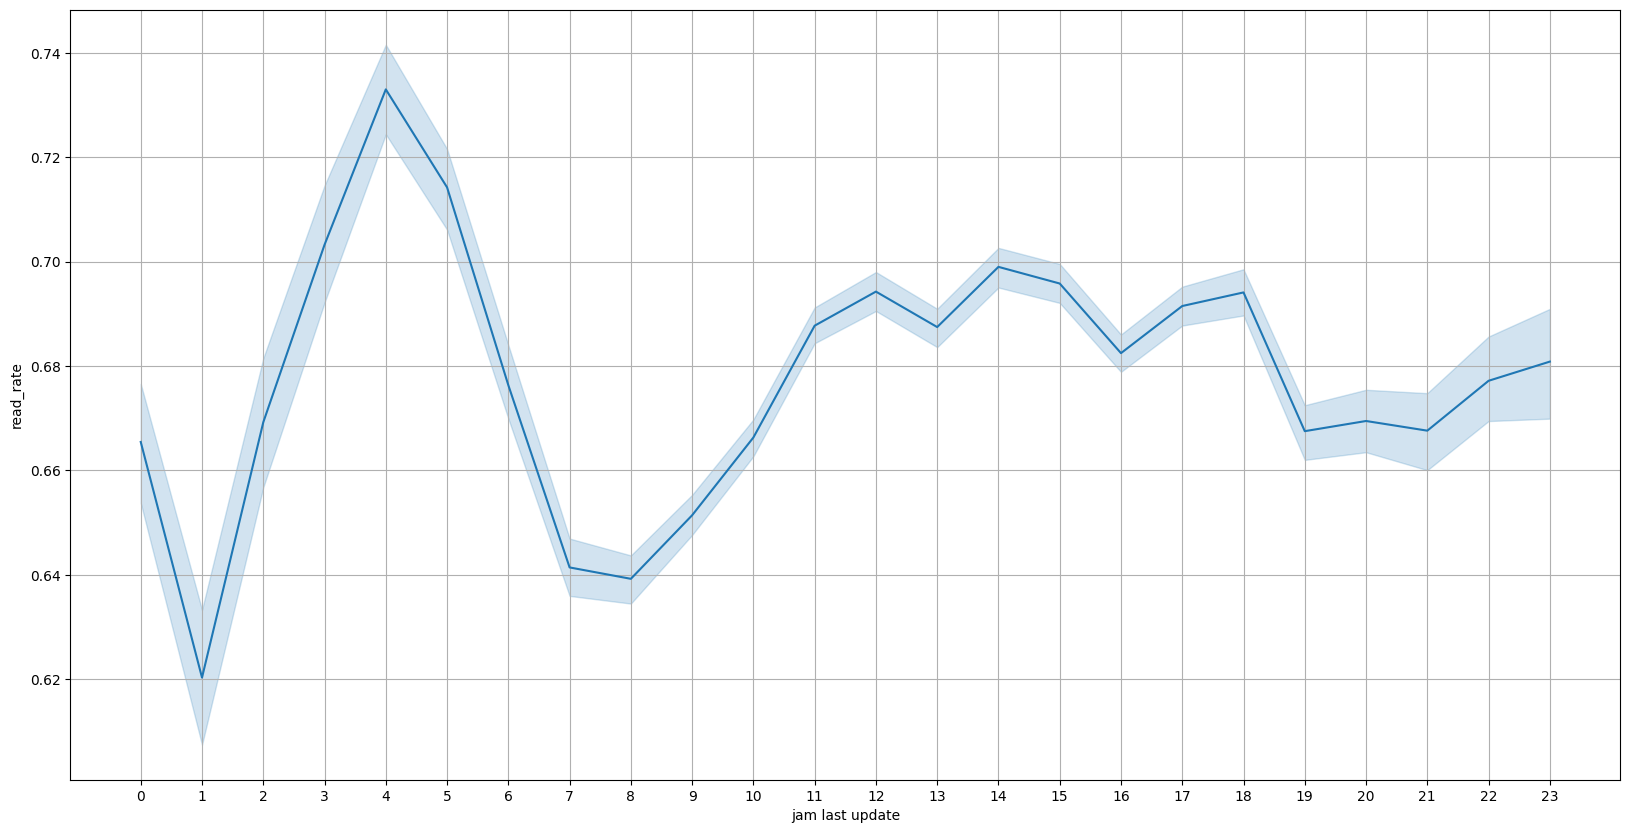

In [51]:
fig, ax = plt.subplots(figsize=(20,10))
# sns.barplot(x=groupby.jam, y=groupby['persentase_terbaca'], data=groupby, palette='Blues_d', ci=None, order=groupby.sort_values(by='persentase_terbaca', ascending=False).index, ax=ax)

sns.lineplot(data=groupby, y=groupby['read_rate'], x=groupby['jam last update'], ax=ax)
# sns.scatterplot(data=groupby, y=groupby['read_rate'], hue=groupby.hari, x=groupby.jam, ax=ax, legend=False)
plt.grid(True)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]);

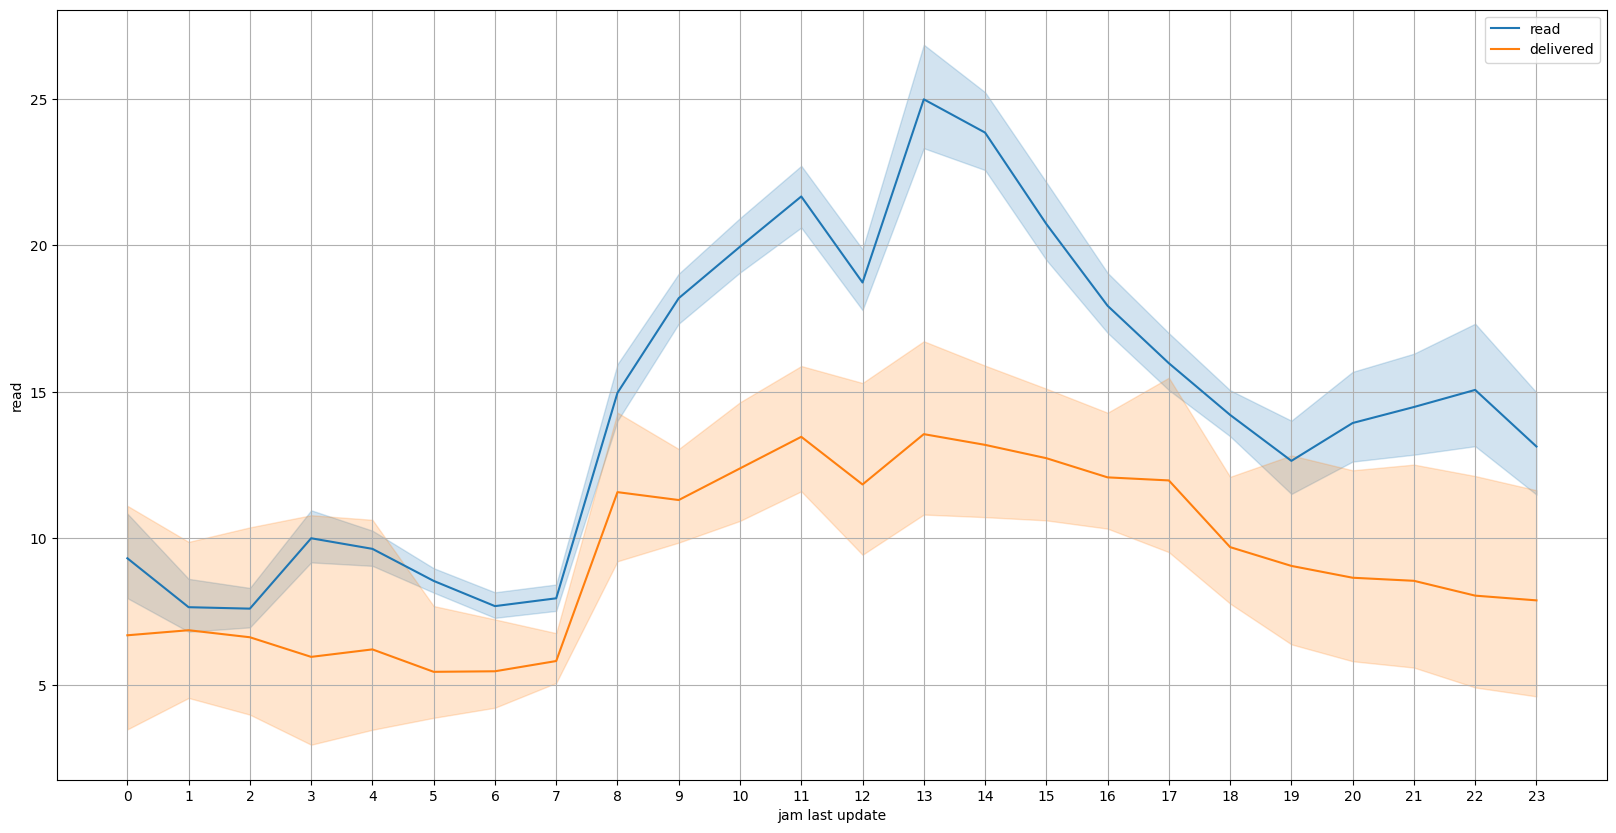

In [52]:
fig, ax = plt.subplots(figsize=(20,10))
# sns.barplot(x=groupby.jam, y=groupby['read_rate'], data=groupby, palette='Blues_d', ci=None, order=groupby.sort_values(by='read_rate', ascending=False).index, ax=ax)

sns.lineplot(data=groupby, y=groupby['read'],x=groupby['jam last update'], ax=ax, label='read')
sns.lineplot(data=groupby, y=groupby['delivered'], x=groupby.jam, ax=ax, label='delivered')
plt.grid(True)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]);

In [53]:
groupby.groupby(['jam last update']).sum().iloc[:,3:5]

C:\Users\Jayy\AppData\Local\Temp\ipykernel_13564\1024043572.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  groupby.groupby(['jam last update']).sum().iloc[:,3:5]


Status,delivered,read
jam last update,,
0,13499.0,11247.0
1,15370.0,9070.0
2,10296.0,9870.0
3,8774.0,15562.0
4,9103.0,18373.0
5,11212.0,24046.0
6,13358.0,27233.0
7,25747.0,42841.0
8,111808.0,130082.0


In [54]:
groupby.columns.shape

(18,)

In [55]:
groupby.to_csv("../../data/data_olahan_groupby ada selisihnya 3.csv", index=False)

In [56]:
groupby.isnull().sum()

Status
Email User              0
provider                0
hari                    0
hari last update        0
jam                     0
jam last update         0
tanggal                 0
tanggal last update     0
selisih                32
delivered               0
read                    0
total                   0
read_rate               0
read scalled            0
delivered scalled       0
weighted                0
is_weekend              0
is_working_hour         0
dtype: int64

In [57]:
groupby.dtypes

Status
Email User              object
provider                object
hari                    object
hari last update        object
jam                      int64
jam last update          int64
tanggal                  int64
tanggal last update      int64
selisih                 object
delivered              float64
read                   float64
total                  float64
read_rate              float64
read scalled           float64
delivered scalled      float64
weighted               float64
is_weekend              object
is_working_hour         object
dtype: object

In [58]:
groupby

Status,Email User,provider,hari,hari last update,jam,jam last update,tanggal,tanggal last update,selisih,delivered,read,total,read_rate,read scalled,delivered scalled,weighted,is_weekend,is_working_hour
0,Email user 161,Telkomsel,Rabu,Rabu,13,13,15,15,kurang dari satu jam,5841.0,4996.0,10837.0,0.461013,1.000000,0.326202,0.999326,Weekday,Working Hour
1,Email user 161,Telkomsel,Senin,Senin,15,15,20,20,kurang dari satu jam,6615.0,4438.0,11053.0,0.401520,0.888288,0.369435,0.887769,Weekday,Working Hour
2,Email user 49,Telkomsel,Sabtu,Sabtu,12,12,25,25,kurang dari satu jam,17904.0,4047.0,21951.0,0.184365,0.810010,1.000000,0.810200,Weekend,Non Working Hour
3,Email user 161,Telkomsel,Senin,Senin,13,13,13,13,kurang dari satu jam,1857.0,3772.0,5629.0,0.670101,0.754955,0.103670,0.754304,Weekday,Working Hour
4,Email user 161,Telkomsel,Rabu,Rabu,15,15,15,15,kurang dari satu jam,911.0,3646.0,4557.0,0.800088,0.729730,0.050829,0.729051,Weekday,Working Hour
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180940,Email user 19,Telkomsel,Selasa,Selasa,15,15,14,14,kurang dari satu jam,1.0,1.0,2.0,0.500000,0.000000,0.000000,0.000000,Weekday,Working Hour
180941,Email user 19,Telkomsel,Selasa,Selasa,15,15,28,28,kurang dari satu jam,1.0,1.0,2.0,0.500000,0.000000,0.000000,0.000000,Weekday,Working Hour
180942,Email user 19,Telkomsel,Selasa,Selasa,18,18,7,7,kurang dari satu jam,1.0,1.0,2.0,0.500000,0.000000,0.000000,0.000000,Weekday,Non Working Hour
180943,Email user 19,Telkomsel,Selasa,Selasa,17,17,31,31,kurang dari satu jam,1.0,1.0,2.0,0.500000,0.000000,0.000000,0.000000,Weekday,Working Hour


In [59]:
groupby[(groupby['hari last update'] == 'Senin') & (groupby['jam last update'] == 12)].sort_values(by=['weighted'], ascending=False)

Status,Email User,provider,hari,hari last update,jam,jam last update,tanggal,tanggal last update,selisih,delivered,read,total,read_rate,read scalled,delivered scalled,weighted,is_weekend,is_working_hour
305,Email user 39,Telkomsel,Senin,Senin,12,12,27,27,kurang dari satu jam,364.0,532.0,896.0,0.593750,0.106306,0.020276,0.106220,Weekday,Working Hour
410,Email user 39,Telkomsel,Senin,Senin,12,12,27,27,kurang dari satu jam,1216.0,457.0,1673.0,0.273162,0.091291,0.067866,0.091268,Weekday,Working Hour
504,Email user 39,Telkomsel,Senin,Senin,12,12,9,9,kurang dari satu jam,186.0,405.0,591.0,0.685279,0.080881,0.010333,0.080810,Weekday,Working Hour
506,Email user 39,Telkomsel,Senin,Senin,12,12,9,9,kurang dari satu jam,299.0,404.0,703.0,0.574680,0.080681,0.016645,0.080617,Weekday,Working Hour
654,Email user 165,Telkomsel,Senin,Senin,12,12,6,6,kurang dari satu jam,62.0,344.0,406.0,0.847291,0.068669,0.003407,0.068603,Weekday,Working Hour
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162057,Email user 57,Telkomsel,Senin,Senin,11,12,2,2,kurang dari satu jam,1.0,1.0,2.0,0.500000,0.000000,0.000000,0.000000,Weekday,Working Hour
162064,Email user 45,Telkomsel,Senin,Senin,10,12,27,27,1 jam,1.0,1.0,2.0,0.500000,0.000000,0.000000,0.000000,Weekday,Working Hour
162445,Email user 142,Telkomsel,Minggu,Senin,13,12,12,13,23 jam,1.0,1.0,2.0,0.500000,0.000000,0.000000,0.000000,Weekend,Non Working Hour
162447,Email user 142,Telkomsel,Minggu,Senin,13,12,12,13,23 jam,1.0,1.0,2.0,0.500000,0.000000,0.000000,0.000000,Weekend,Non Working Hour


In [60]:
groupby['rrw'] = (groupby['read_rate'] * 0.1) + (groupby['weighted'] * 0.9)

In [63]:
groupby.groupby('hari last update').sum()

C:\Users\Jayy\AppData\Local\Temp\ipykernel_13564\3845622757.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  groupby.groupby('hari last update').sum()


Status,jam,jam last update,tanggal,tanggal last update,delivered,read,total,read_rate,read scalled,delivered scalled,weighted,rrw
hari last update,,,,,,,,,,,,
Jumat,358538,374243,488955,489415,326699.0,472506.0,799205.0,18701.350803,88.927127,16.666704,88.854867,1950.104460
Kamis,305104,314107,365731,365969,264183.0,390486.0,654669.0,15648.256007,73.384184,13.419594,73.324220,1630.817398
Minggu,243429,224092,470367,474848,149965.0,240173.0,390138.0,16504.587963,43.336937,7.052449,43.300652,1689.429384
Rabu,313315,327528,357441,355950,279792.0,442733.0,722525.0,16238.579796,83.758158,14.267497,83.688667,1699.177780
Sabtu,403195,433809,635113,635459,518819.0,839523.0,1358342.0,23642.159892,161.727928,27.209239,161.593409,2509.650058
Selasa,316051,316888,462641,463798,257787.0,409178.0,666965.0,16216.432212,76.985586,13.023069,76.921623,1690.872682
Senin,312655,319999,412387,414150,268575.0,440529.0,709104.0,16059.664103,83.328128,13.644082,83.258444,1680.899010


In [61]:
groupby[(groupby['hari last update'] == 'Selasa')].drop(columns=['read scalled', 'delivered scalled']).sort_values(by='rrw', ascending=False)

Status,Email User,provider,hari,hari last update,jam,jam last update,tanggal,tanggal last update,selisih,delivered,read,total,read_rate,weighted,is_weekend,is_working_hour,rrw
6,Email user 161,Telkomsel,Selasa,Selasa,13,13,14,14,kurang dari satu jam,5657.0,3456.0,9113.0,0.379238,0.691316,Weekday,Working Hour,0.660108
10,Email user 161,Telkomsel,Selasa,Selasa,13,13,28,28,kurang dari satu jam,10492.0,3269.0,13761.0,0.237555,0.654186,Weekday,Working Hour,0.612523
30,Email user 161,Telkomsel,Selasa,Selasa,13,13,28,28,kurang dari satu jam,599.0,1978.0,2577.0,0.767559,0.395433,Weekday,Working Hour,0.432646
40,Email user 161,Telkomsel,Selasa,Selasa,11,11,21,21,kurang dari satu jam,566.0,1770.0,2336.0,0.757705,0.353832,Weekday,Working Hour,0.394219
56,Email user 161,Telkomsel,Selasa,Selasa,13,13,14,14,kurang dari satu jam,334.0,1536.0,1870.0,0.821390,0.307019,Weekday,Working Hour,0.358456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177577,Email user 188,Indosat,Selasa,Selasa,8,8,24,24,kurang dari satu jam,64.0,1.0,65.0,0.015385,0.000004,Weekday,Working Hour,0.001542
137439,Email user 25,Telkomsel,Selasa,Selasa,10,10,10,10,kurang dari satu jam,150.0,2.0,152.0,0.013158,0.000208,Weekday,Working Hour,0.001503
173051,Email user 25,Telkomsel,Selasa,Selasa,17,17,24,24,kurang dari satu jam,72.0,1.0,73.0,0.013699,0.000004,Weekday,Working Hour,0.001373
171955,Email user 116,Indosat,Selasa,Selasa,1,1,28,28,kurang dari satu jam,77.0,1.0,78.0,0.012821,0.000004,Weekday,Non Working Hour,0.001286
